In [9]:
from matplotlib import pyplot as plt
import numpy as np
import glob
import datetime as dt
import pandas as pd
import logging
logging.getLogger().setLevel("ERROR")


def average_volume(filename, month, ts_sum=False):
    df = pd.read_csv(filename, delimiter=" ", names=["time", "flow"])
    df["time"] = pd.to_datetime(df['time'], unit='s')

    df = df[df['time'].dt.month == month]
    values =np.zeros(24)
    epoch = dt.datetime.utcfromtimestamp(0)
    day_count = 0
    volume = np.zeros(24)
    for i in range(1, 31):
        df_day = df[df['time'].dt.day == i]
        if len(df_day) > 0:
            day_count +=1
            for j in (range(0,24)):
                df_hour = df_day[df_day['time'].dt.hour == j]
                if len(df_hour) > 0:
                    df_epoch = (df_hour["time"] - epoch).dt.total_seconds()
                    df_epoch = df_epoch.to_numpy()

                    df_values = df_hour["flow"].to_numpy()

                    if not ts_sum:
                        values[j] = 0
                    else:
                        values [j] = df_values[0]

                    for h in range(1, len(df_values)):
                        if not ts_sum:
                            values[j] += 0.5 * (df_epoch[h] - df_epoch[h - 1]) * (df_values[h] + df_values[h - 1]) / 3600
                        else:
                            values[j] += df_values[h]
                    volume[j] += values[j]
        var_cum=[values[0]]
        for h in range(1,len(values)):
            var_cum.append(var_cum[-1]+values[h])

    volume = volume / day_count
    vol_cum = [volume[0]]
    for h in range(1, len(volume)):
        vol_cum.append(vol_cum[-1] + volume[h])
    return np.array(vol_cum)



def cumulative_sim_volume(sim_dir, ts_sum):

    sim_ts = glob.glob(sim_dir+"/user_*.csv")
    simulated = np.zeros(24)
    for ts_file in sim_ts:
        ts_flow = np.genfromtxt(ts_file, delimiter=",")
        if not ts_sum:
            values = [0]
        else:
            values = [ts_flow[0,1]]
        for i in range(1, len(ts_flow)):
            if not ts_sum:
                increment = (0.5 * (ts_flow[i,0]-ts_flow[i-1,0]) * (ts_flow[i,1]+ts_flow[i-1,1]))/3600
            else:
                increment = ts_flow[i,1]
            values.append(values[i-1] + increment)
            this_hour = int(ts_flow[i-1, 0]/3600)
            if this_hour < 24:
                simulated[int(ts_flow[i-1, 0]/3600)] += increment

    cum = [simulated[0]]
    for i in range(1, len(simulated)):
        cum.append((cum[-1] + simulated[i]))

    for i in range(len(cum)):
        cum[i] /= len(sim_ts)

    return cum


def plot_var(sim_dirs):
    all_ts = None
    for sim_dir in sim_dirs:
        temp_ts = np.genfromtxt(sim_dir+"/cum_average.csv")
        if all_ts is None:
            all_ts =[temp_ts]
        else:
            all_ts = np.vstack((all_ts, temp_ts))

    average = np.average(all_ts, axis=0)

    stderr = np.std(all_ts, axis=0)

    return average, stderr, all_ts


def all_sim_average(all_dirs, ts_sum):

    for sim_dir in all_dirs:
        logging.info("processing  " + sim_dir)
        c = cumulative_sim_volume(sim_dir, ts_sum)
        np.savetxt(sim_dir + "/cum_average.csv", c)


def plot(timeseries = "Washbasin",  month = 6, ts_sum=False):

    sim_dirs = glob.glob("../../data/csv_"+timeseries+"/simulation*")
    all_sim_average(sim_dirs, ts_sum)
    av_volume = average_volume("../../data/feed_"+timeseries+".MYD.csv", month, ts_sum)
    av, std_av, all_ts = plot_var(sim_dirs)
    err = np.abs(av_volume-av)
    all_err = np.abs(all_ts - av_volume)
    std_err = np.std(all_err, axis=0)
    x_hours = np.arange(0, 24, 1)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x_hours, av, alpha=0.5, color='blue', label=' simulated consumption')
    ax.plot(x_hours, av_volume, alpha=0.5, color='black', label=' measured consumption')
    ax.plot(x_hours, err, alpha=0.5, color='red', label='error')


    y1 = av - std_av
    y2 = av + std_av
    y1[y1 < 0] = 0
    z1 = err - 2 * std_av
    z1[z1 < 0] = 0

    ax.fill_between(x_hours, y1, y2, color='#888888', alpha=0.4)
    ax.fill_between(x_hours, z1,
                    av + 2 * std_av, color='#888888', alpha=0.)
    '''


    y1 = err - std_err
    y2 = err + std_err
    y1[y1<0] = 0
    z1= err - 2 * std_err
    z1[z1<0] = 0
    # ax.fill_between(x_hours, y1, y2, color='#888888', alpha=0.4)
    # ax.fill_between(x_hours, z1,
    #                err + 2 * std_err, color='#888888', alpha=0.2)
    '''
    ax.set_xlabel("hour")
    ax.set_ylabel("Volume [liters]")
    plt.grid()
    plt.legend()
    plt.show()

    i_max = np.argmax(err)
    i_min = np.argmin(err)


    print(timeseries + ": err_max=", np.max(err), ", ",np.max(err)/av_volume[i_max],": err_min=", np.min(err),",",np.min(err)/av_volume[i_min], " err_mean=", np.average(err))
    print(timeseries + ": var_max=", np.max(std_err), " var_min=", np.min(std_err), " var_mean=", np.average(std_err))

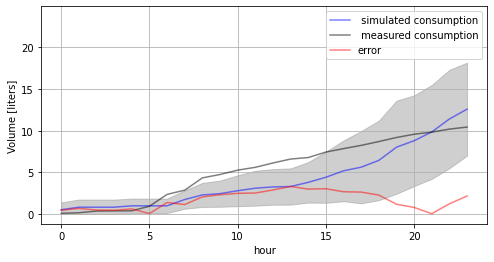

Washbasin: err_max= 3.300382824296303 ,  0.5007907825620266 : err_min= 0.024673256856473813 , 0.0025115096517428557  err_mean= 1.6484969657642774
Washbasin: var_max= 3.5510031053435713  var_min= 0.36852323739500137  var_mean= 1.7804464856591868


In [10]:
plot("Washbasin",  6, False)

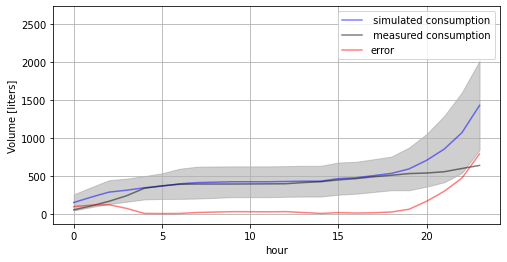

AMPDS1Y: err_max= 791.2736605333336 ,  1.23859068722444 : err_min= 4.660924033333288 , 0.012575000764422736  err_mean= 102.76048996805554
AMPDS1Y: var_max= 563.0970311337171  var_min= 86.17955527643254  var_mean= 162.87537659755435


In [11]:
plot("AMPDS1Y",  8, True)

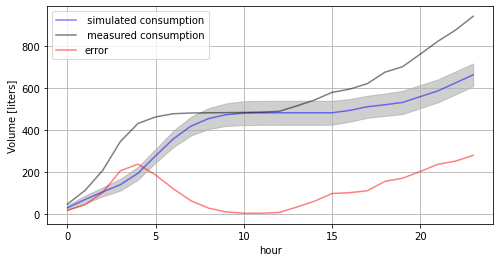

AMPDScut: err_max= 279.35894343128405 ,  0.29627981273645493 : err_min= 3.329162883281242 , 0.0068788304998062735  err_mean= 113.49018601028972
AMPDScut: var_max= 55.3895774299602  var_min= 9.804339379197708  var_mean= 40.40149969370097


In [12]:
plot("AMPDScut",  8, True)
